In [1]:
import numpy as np
import pandas as pd
import sklearn

import time
import os
import re
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

C:\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


# ArXiv Metadata Cleanup

---

# Summary:
* Load the csv's created by the harvester
* remove nans, some *withdrawn* articles, and duplicates; review records with very little data
* extract the primary label
* select features (throw away *id*, *authors*, subcategories and secondary categories)
* examine volumes of each label
* remove two categories altogether (*econ*, *eess*)
* remove excess whitespaces
* shuffle and save to file (*./data/bare_all.csv)

### Sidenote: if one ever wants know more about any of the articles, display its metadata with proper formatting or reach the actual pdf, it is enough to simply search the internet for the '*id*' (or 'arxiv *id*' in the worst case).

---

## Load the data

In [159]:
# dir_ = os.path.join("data", "arXivMeta_sample")
dir_ = os.path.join("data", "arXivMeta_all")

file_list = []
for file in os.listdir(dir_):
    file_path = os.path.join(dir_, file)
    file_list.append(file_path)
    print(f"using {file}")
    
all_data = pd.concat([pd.read_csv(file, delimiter='\t', na_values='nan') for file in file_list])

using arXivMeta_all_from_2010-01-01_to_2010-07-01.csv
using arXivMeta_all_from_2010-07-02_to_2010-12-31.csv
using arXivMeta_all_from_2011-01-01_to_2011-07-01.csv
using arXivMeta_all_from_2011-07-02_to_2011-12-31.csv
using arXivMeta_all_from_2012-01-01_to_2012-07-01.csv
using arXivMeta_all_from_2012-07-02_to_2012-12-31.csv
using arXivMeta_all_from_2013-01-01_to_2013-07-01.csv
using arXivMeta_all_from_2013-07-02_to_2013-12-31.csv
using arXivMeta_all_from_2014-01-01_to_2014-07-01.csv
using arXivMeta_all_from_2014-07-02_to_2014-12-31.csv
using arXivMeta_all_from_2015-01-01_to_2015-07-01.csv
using arXivMeta_all_from_2015-07-02_to_2015-12-31.csv
using arXivMeta_all_from_2016-01-01_to_2016-07-01.csv
using arXivMeta_all_from_2016-07-02_to_2016-12-31.csv
using arXivMeta_all_from_2017-01-01_to_2017-07-01.csv
using arXivMeta_all_from_2017-07-02_to_2017-12-31.csv


---

## Handle NaNs

In [54]:
# count the NaNs
all_data.isnull().sum()

id            10
authors        0
title         10
abstract      10
categories    10
dtype: int64

In [87]:
# show the NaNs
rows_with_nulls = all_data.isnull().any(axis=1)
print("No. of rows with NaNs: ", sum(rows_with_nulls))
all_data[rows_with_nulls][:3]

No. of rows with NaNs:  10


,id,authors,title,abstract,categories
22299,NaN,[],NaN,NaN,NaN
22300,NaN,[],NaN,NaN,NaN
23584,NaN,[],NaN,NaN,NaN


In [160]:
# All the NaNs are aligned in empty rows.
# We can just drop them.
all_data = all_data.dropna(axis=0, how='any', inplace=False)
all_data.isnull().sum().sum()

0

## Remove records that start with *This paper has been withdrawn* etc.

In [161]:
# r'^\s*(?:withdrawn)|(?:Withdrawn)|(?:Paper withdrawn)|(?:Article withdrawn)|(?:The paper has been withdrawn)|(?:This submission has been withdrawn)|(?:This article has been withdrawn)|(?:This paper has been withdrawn)|(?:This paper is withdrawn)|(?:Administratively withdrawn)|(?:arXiv admin note: This submission has been withdrawn)|(?:Admin note: withdrawn by arXiv)'
# r'[Ww]ithdrawn|[Rr]etracted'
flag_string = r'''^\s*(administratively|(arXiv)*\sadmin\snote:*)*\s*(the|this)*\s*(version\s+(of)*)*\s*(the|this)*\s*(articles*|papers*|submissions*|pre-*prints*|comments*|reviews*)*\s*(have\s+been|have|has\s+been|is|was|is\s+being|are|are\s+being)*\s*(withdrawn|retracted)'''
redflags = re.compile(flag_string, re.IGNORECASE)

withdrawn_abstract = all_data.abstract.str.contains(redflags)
withdrawn_title = all_data.title.str.contains(redflags)

print(f"Removing {sum(withdrawn)} articles that seem to have been withdrawn.")
all_data = all_data[~withdrawn_abstract]
all_data = all_data[~withdrawn_title]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


Removing 477 articles that seem to have been withdrawn.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


ValueError: cannot reindex from a duplicate axis

## Reviewing suspiciously short texts
There are articles where the abstract serves as a comment rather than a summary, e.g. "Discussion on SOME_REFERENCE."

In [145]:
example = all_data[all_data.id == '1001.2975'].abstract.values[0].strip()
print(example)
len(example)

Comment on "Harold Jeffreys's Theory of Probability Revisited"
[arXiv:0804.3173]


80

Have a look at short abstracts and short text+abstract concatenations

In [149]:
display( all_data[all_data.abstract.str.len() < 25] )
display( all_data[all_data.title.str.len() + all_data.abstract.str.len() < 60] )

,id,authors,title,abstract,categories
1504,0811.2543,['Joydip Ghosh'],A Non-Renormalized Field Theoretic Treatment o...,NA\n,quant-ph
12998,hep-th/9905181,['Jorgen Rasmussen'],Superconformal Algebras on the Boundary of AdS_3,See hep-th/0002188\n,hep-th math.QA
17351,0909.0251,"['Kazi Mohammed Saidul Huq', 'Miguel Bergano',...",Channel Equalization in Digital Transmission,not required\n,cs.IT math.IT
680,0810.5629,"['Tiancheng Ouyang', 'Duokui Yan']",Simultaneous Binary Collisions for Collinear F...,SBC is not done\n,math.DS
6699,1008.2836,['M. Jagadesh Kumar'],Memristor: Why do we have to know about it?,Review on Memristor.\n,cond-mat.mes-hall
16241,1009.1483,['Timo Spielmann'],Multi-Hyper-Nuclei Production in Anti-Proton I...,we do not pulish this\n,nucl-th
17847,1010.3314,"['Alexandru Herescu', 'Jeffrey S. Allen']",Hydraulic Jump in a Nonwetting Film Deposited ...,Fluid dynamics video\n,physics.flu-dyn
17283,0902.0680,['Michael Björklund'],Ergodic Theorems for Homogeneous Dilations,Revision.\r\n,math.DS math.CA
17789,0909.3549,"['Pablo Suárez-Serrato', 'Alberto Verjovsky']",A smooth codimension-one foliation of the five...,.\r\n,math.SG math.GT
4055,1101.3937,['Helmut Satz'],The Quark-Gluon Plasma,A Short Introduction\r\n,hep-ph


,id,authors,title,abstract,categories
2193,0903.0869,['Mark Pankov'],Note on half-cube embeddings,Results are well-known\n,math.CO
17351,0909.0251,"['Kazi Mohammed Saidul Huq', 'Miguel Bergano',...",Channel Equalization in Digital Transmission,not required\n,cs.IT math.IT
28105,quant-ph/0109130,"['Yakir Aharonov', 'Jeeva Anandan', 'Shmuel Nu...",Coherent Decays of Atoms,Re-considering this work.\n,quant-ph
17283,0902.0680,['Michael Björklund'],Ergodic Theorems for Homogeneous Dilations,Revision.\r\n,math.DS math.CA
4055,1101.3937,['Helmut Satz'],The Quark-Gluon Plasma,A Short Introduction\r\n,hep-ph
5454,1104.4657,"['Shaolei Ren', 'Jaeok Park', 'Mihaela van der...",Business Mode Selection in Digital Content Mar...,NA\r\n,cs.SI
6004,1201.0214,['Joan S. Birman'],Lorenz knots,This is a review article on Lorenz knots.\r\n,math.GT math.DS
26110,1210.7958,['Pramod Kumar Sharma'],Excursions in Group Theory,This is a book on Group.\r\n,math.GR
10004,1312.6634,['R. Jackiw'],Ken Wilson -- The Early Years,Ken Wilson is remembered.\r\n,physics.hist-ph cond-mat.stat-mech hep-th
156676,astro-ph/0511670,['Tim de Zeeuw'],Island Universes,Conference Summary\r\n,astro-ph


Except perhaps for an occasional laudation, there don't seem to be any completely noisy data here. We will retain it all.

In [152]:
# # Removing records with little text

# tresh = 20
# too_short = (all_data.title.str.len()+all_data.abstract.str.len() < tresh)
# print(f"Removing {sum(too_short)} records with text data shorter than {tresh}.")
# all_data = all_data.loc[all_data.abstract.str.len() > tresh]

## Check for repeated entries

In [153]:
# Count remaining duplicates in each column separately

print("No. repeated entries in column:")
for column in all_data:
    print( f"{column:<11}", len(all_data) - len(all_data[column].unique()) )

No. repeated entries in column:
id          0
authors     215219
title       1070
abstract    414
categories  803377


In [ ]:
# As a sidenote, recall how does the *duplicated* function in pandas actually work.
# It flags the duplicates starting from the second repeated entry.

df = pd.DataFrame({'a': [1,1,1], 'b': [2,2,3], 'c': [4,5,6]})
print(df.duplicated(subset=['a','b']))

# To get all repeats use the *keep=False* argument
print(df.duplicated(subset=['a','b'], keep=False))

In [ ]:
# Back to our data.
# There are entries with duplicated abstracts and matching categories.
# The fact that they may have differing titles and authors is fishy but
# it's probably due to typo in the title or added authors

subset=['abstract', 'categories']
duplicates_1 = all_data[all_data.duplicated(subset=subset, keep=False)]
display(pd.concat(g for _, g in duplicates_1.groupby(subset) ))

# This data represents unambiguous mapping from abstracts to categories
# so we want to retain one entry from each bunch of duplicates

print(f"Something wrong with ids, authors or titles above. Keep one of each unique abstract.")
all_data = all_data.drop_duplicates(subset=subset)

In [ ]:
# Now, remaining duplicated abstracts must have differing categories at this point.
# Thus, those records are ambigous for our purposes, and we may want to drop them all.
# Alas, the differing categories are probably 'close' and they likely have the same top-level category.
# So, to not throw away reasonably informative data but to still keep unambiguous abstract->categories map,
# we'll again keep one of the duplicates.
# One may add *keep=False* to *drop_duplicates* below, in order to remove them all.

subset=['abstract']
duplicates_2 = all_data[all_data.duplicated(subset=subset, keep=False)]
display(pd.concat(g for _, g in duplicates_2.groupby(subset) ))

print(f"Ambiguous categories. Keep one of each unique abstract.")
all_data = all_data.drop_duplicates(subset=subset)
# all_data = all_data.drop_duplicates(subset=subset, keep=False)

In [162]:
# At this point there are no duplicated abstracts.
# The duplicated titles could be examined and perhaps removed as well
# but we will not bother to do that

print("No. all records:", len(all_data))
print("No. repeated entries in column:")
for column in all_data:
    print( f"{column:<11}", len(all_data) - len(all_data[column].unique()) )

No. all records: 840229
No. repeated entries in column:
id          0
authors     215220
title       1070
abstract    415
categories  803378


---

## Extract the first category as the primary category of each article

In [163]:
# Although it is not visibly indicated in the dataset,
# the first categories in a list are the primary_categories of each article.
# We make a new column for them.

primary_categories = all_data.categories.str.split().str[0]
all_data['primary_cat'] = primary_categories
all_data[9:12]

,id,authors,title,abstract,categories,primary_cat
9,0704.0842,['Chengguang Bao'],Oscillation bands of condensates on a ring: Be...,The Hamiltonian of a N-boson system confined...,cond-mat.other,cond-mat.other
10,0704.1074,"['Satoshi Aoki', 'Takayuki Hibi', 'Hidefumi Oh...",Markov basis and Groebner basis of Segre-Veron...,We consider testing independence in group-wi...,math.ST math.AC stat.AP stat.TH,math.ST
11,0704.1083,['Laurent Berger'],"B-pairs and (phi,Gamma)-modules",Main change from v1 : theorem C has been mod...,math.NT math.AG,math.NT


## Map all the categories into top-level topics (*physics*, *mathematics*, etc.)

### Start with creating a mapping

In [164]:
# Read in categories described in the *arXiv_metadata_harvester.ipynb*

from my_utilities import read_dict

physics_genres = read_dict("physics_genres.txt")
print(physics_genres) # That's just what arXiv's API told us

top_cats = read_dict("top_cats.txt")
top_cats # We want those as labels for our categories

{'astro-ph': 'Astrophysics', 'cond-mat': 'Condensed Matter', 'gr-qc': 'General Relativity and Quantum Cosmology', 'hep-ex': 'High Energy Physics - Experiment', 'hep-lat': 'High Energy Physics - Lattice', 'hep-ph': 'High Energy Physics - Phenomenology', 'hep-th': 'High Energy Physics - Theory', 'math-ph': 'Mathematical Physics', 'nlin': 'Nonlinear Sciences', 'nucl-ex': 'Nuclear Experiment', 'nucl-th': 'Nuclear Theory', 'physics': 'Physics (Other)', 'quant-ph': 'Quantum Physics'}


{'cs': 'Computer Science',
 'econ': 'Economics',
 'eess': 'Electrical Engineering and Systems Science',
 'math': 'Mathematics',
 'physics': 'Physics',
 'q-bio': 'Quantitative Biology',
 'q-fin': 'Quantitative Finance',
 'stat': 'Statistics'}

In [169]:
# Let's have a look at all possible categories

categories_set = set()
for cats in all_data.categories.str.split():
    categories_set.update(set(cats))

categories = pd.Series(list(categories_set))

print(f"We have {len(categories)} unique category labels so far:")
categories_set

We have 173 unique category labels so far:


{'acc-phys',
 'adap-org',
 'alg-geom',
 'ao-sci',
 'astro-ph',
 'astro-ph.CO',
 'astro-ph.EP',
 'astro-ph.GA',
 'astro-ph.HE',
 'astro-ph.IM',
 'astro-ph.SR',
 'atom-ph',
 'bayes-an',
 'chao-dyn',
 'chem-ph',
 'cmp-lg',
 'comp-gas',
 'cond-mat',
 'cond-mat.dis-nn',
 'cond-mat.mes-hall',
 'cond-mat.mtrl-sci',
 'cond-mat.other',
 'cond-mat.quant-gas',
 'cond-mat.soft',
 'cond-mat.stat-mech',
 'cond-mat.str-el',
 'cond-mat.supr-con',
 'cs.AI',
 'cs.AR',
 'cs.CC',
 'cs.CE',
 'cs.CG',
 'cs.CL',
 'cs.CR',
 'cs.CV',
 'cs.CY',
 'cs.DB',
 'cs.DC',
 'cs.DL',
 'cs.DM',
 'cs.DS',
 'cs.ET',
 'cs.FL',
 'cs.GL',
 'cs.GR',
 'cs.GT',
 'cs.HC',
 'cs.IR',
 'cs.IT',
 'cs.LG',
 'cs.LO',
 'cs.MA',
 'cs.MM',
 'cs.MS',
 'cs.NA',
 'cs.NE',
 'cs.NI',
 'cs.OH',
 'cs.OS',
 'cs.PF',
 'cs.PL',
 'cs.RO',
 'cs.SC',
 'cs.SD',
 'cs.SE',
 'cs.SI',
 'cs.SY',
 'dg-ga',
 'econ.EM',
 'eess.AS',
 'eess.IV',
 'eess.SP',
 'funct-an',
 'gr-qc',
 'hep-ex',
 'hep-lat',
 'hep-ph',
 'hep-th',
 'math-ph',
 'math.AC',
 'math.AG',
 'm

In [170]:
# Extract the first level categorization, i.e. up to a dot or end of string,
# e.g. cond-mat.quant-gas -> cond-mat, cs.AI -> cs

strip_pattern = re.compile(r'([\w\-]+)')

def strip_to_semitop(cat, pattern=strip_pattern):
    return strip_pattern.match(cat).group(1)

semitop_categories = categories.map(strip_to_semitop)
semitop_categories_set = set(semitop_categories)    

semitop_categories_set

{'acc-phys',
 'adap-org',
 'alg-geom',
 'ao-sci',
 'astro-ph',
 'atom-ph',
 'bayes-an',
 'chao-dyn',
 'chem-ph',
 'cmp-lg',
 'comp-gas',
 'cond-mat',
 'cs',
 'dg-ga',
 'econ',
 'eess',
 'funct-an',
 'gr-qc',
 'hep-ex',
 'hep-lat',
 'hep-ph',
 'hep-th',
 'math',
 'math-ph',
 'mtrl-th',
 'nlin',
 'nucl-ex',
 'nucl-th',
 'patt-sol',
 'physics',
 'plasm-ph',
 'q-alg',
 'q-bio',
 'q-fin',
 'quant-ph',
 'solv-int',
 'stat',
 'supr-con'}

In [171]:
# Try to create map from semitop_categories to top_cats using physic_genres

to_top = {}

for top_cat in top_cats:
    to_top[top_cat] = top_cat
    
for genre in physics_genres:
    # writes over to_top[physics]=physics
    to_top[genre] = "phys"
    
to_top

{'cs': 'cs',
 'econ': 'econ',
 'eess': 'eess',
 'math': 'math',
 'physics': 'phys',
 'q-bio': 'q-bio',
 'q-fin': 'q-fin',
 'stat': 'stat',
 'astro-ph': 'phys',
 'cond-mat': 'phys',
 'gr-qc': 'phys',
 'hep-ex': 'phys',
 'hep-lat': 'phys',
 'hep-ph': 'phys',
 'hep-th': 'phys',
 'math-ph': 'phys',
 'nlin': 'phys',
 'nucl-ex': 'phys',
 'nucl-th': 'phys',
 'quant-ph': 'phys'}

In [172]:
# let's see which semitop_categories will not be mapped by the 'to_top' dict

semitop_categories[pd.isnull(semitop_categories.map(to_top))]

12     solv-int
43     patt-sol
44     funct-an
51     alg-geom
56     bayes-an
70     plasm-ph
71     supr-con
85      chem-ph
110    chao-dyn
113    acc-phys
117     atom-ph
120      ao-sci
125    adap-org
145     mtrl-th
155    comp-gas
156       dg-ga
157       q-alg
171      cmp-lg
dtype: object

In [173]:
# We just google those, see how arXiv displays them on its frontend, and assign them by hand below

clean_up_mask = {}
clean_up_mask['acc-phys'] = 'physics'
clean_up_mask['adap-org'] = 'nlin'
clean_up_mask['alg-geom'] = 'math'
clean_up_mask['atom-ph'] = 'physics'
clean_up_mask['chao-dyn'] = 'nlin'
clean_up_mask['comp-gas'] = 'nlin'
clean_up_mask['dg-ga'] = 'math'
clean_up_mask['funct-an'] = 'math'
clean_up_mask['q-alg'] = 'math'
clean_up_mask['solv-int'] = 'nlin'
clean_up_mask['patt-sol'] = 'nlin'
clean_up_mask['bayes-an'] = 'physics'
clean_up_mask['supr-con'] = 'cond-mat'
clean_up_mask['chem-ph'] = 'physics'
clean_up_mask['mtrl-th'] = 'cond-mat'
clean_up_mask['cmp-lg'] = 'cs'
clean_up_mask['comp-gas'] = 'nlin'
clean_up_mask['ao-sci'] = 'physics'
clean_up_mask['plasm-ph'] = 'physics'


def clean_up(cat):
    if cat in clean_up_mask:
        return clean_up_mask[cat]
    else:
        return cat


print("Uknown categories:\n", semitop_categories[pd.isnull( semitop_categories.map(clean_up).map(to_top) )] )
print("No. unknown categories:", sum( pd.isnull( semitop_categories.map(clean_up).map(to_top) ) ) )

Uknown categories:
 Series([], dtype: object)
No. unknown categories: 0


### Apply the map

In [174]:
# Ok, assuming there are no uknown categories above,
# we can apply the *strip_to_semitop*, *clean_up* and *to_top* maps to our original categories in the data-frame.
# Pack those three into a vectorized function

def lift_category(cat):
    return to_top[clean_up(strip_to_semitop(cat))]

lift_category = np.vectorize(lift_category)

In [124]:
# # For example

# nico = pd.DataFrame({'a':['cs.AI chao-dyn hep-th']})
# display(nico)

# nico.a = nico.a.str.split().map(lift_category).map(np.unique)
# nico

In [175]:
all_data['top_level_cats'] = all_data.categories.str.split().map(lift_category).map(np.unique)
all_data['primary_top_level_cat'] = all_data.primary_cat.map(lift_category)

In [176]:
all_data[9:12]

,id,authors,title,abstract,categories,primary_cat,top_level_cats,primary_top_level_cat
9,0704.0842,['Chengguang Bao'],Oscillation bands of condensates on a ring: Be...,The Hamiltonian of a N-boson system confined...,cond-mat.other,cond-mat.other,[phys],phys
10,0704.1074,"['Satoshi Aoki', 'Takayuki Hibi', 'Hidefumi Oh...",Markov basis and Groebner basis of Segre-Veron...,We consider testing independence in group-wi...,math.ST math.AC stat.AP stat.TH,math.ST,"[math, stat]",math
11,0704.1083,['Laurent Berger'],"B-pairs and (phi,Gamma)-modules",Main change from v1 : theorem C has been mod...,math.NT math.AG,math.NT,[math],math


---

## Examine the multi-labeldness of data
Our main goal is to predict the *primary_top_level_cat*, but some articles have more than one category in *top_level_cats*. 
Perhaps one could predict the whole list (i.e. several yes/no checks) as well.
For starters let's examine how big a franction of the data has more than one top-level categories

In [177]:
inter6 = sum(all_data.top_level_cats.map(len)>=6)
inter5 = sum(all_data.top_level_cats.map(len)==5)
inter4  = sum(all_data.top_level_cats.map(len)==4)
inter3  = sum(all_data.top_level_cats.map(len)==3)
inter2  = sum(all_data.top_level_cats.map(len)==2)
inter1  = sum(all_data.top_level_cats.map(len)==1)
# inter0  = sum(all_data.top_level_cats.map(len)==0)  # sanity check
inter = inter6 + inter5 + inter4 + inter3 + inter2

print(f"{inter6:>7}/{len(all_data)}={inter6/len(all_data):.3f} with 6 or more categories")
print(f"{inter5:>7}/{len(all_data)}={inter5/len(all_data):.3f} with 5 categories")
print(f"{inter4:>7}/{len(all_data)}={inter4/len(all_data):.3f} with 4 categories")
print(f"{inter3:>7}/{len(all_data)}={inter3/len(all_data):.3f} with 3 categories")
print(f"{inter2:>7}/{len(all_data)}={inter2/len(all_data):.3f} with 2 categories")
print(f"{inter1:>7}/{len(all_data)}={inter1/len(all_data):.3f} with 1 category")
# print(f"{inter0:>7}/{len(all_data)} articles with no category")
print(f"{inter:>7}/{len(all_data)}={inter/len(all_data):.3f} with 2 or more categories")

      0/840229=0.000 with 6 or more categories
     22/840229=0.000 with 5 categories
    450/840229=0.001 with 4 categories
   7768/840229=0.009 with 3 categories
 101412/840229=0.121 with 2 categories
 730577/840229=0.869 with 1 category
 109652/840229=0.131 with 2 or more categories


### 87% percept of records have single top-level category, 1% have three or more. So, we'll focus on single-label classification using the *primary top-level category* (simply referred to as *category* from now on) .

In [178]:
# Have a look at the most interdisciplinary articles :)
all_data[all_data.top_level_cats.map(len)>=5]

,id,authors,title,abstract,categories,primary_cat,top_level_cats,primary_top_level_cat
19119,1001.0036,"['Robert Haslinger', 'Kristina Lisa Klinkner',...",The Computational Structure of Spike Trains,"Neurons perform computations, and convey the...",q-bio.NC cs.IT math.IT nlin.AO physics.data-an...,q-bio.NC,"[cs, math, phys, q-bio, stat]",q-bio
18529,0911.4207,"['Rafael S. Calsaverini', 'Renato Vicente']",An information theoretic approach to statistic...,We discuss the connection between informatio...,q-fin.ST cs.IT math.IT physics.data-an stat.AP,q-fin.ST,"[cs, math, phys, q-fin, stat]",q-fin
28407,1112.0210,"['Karol Wawrzyniak', 'Wojciech Wislicki']",Mesoscopic approach to minority games in herd ...,We study minority games in efficient regime....,nlin.AO cs.MA math.DS q-fin.TR stat.AP,nlin.AO,"[cs, math, phys, q-fin, stat]",phys
30710,cs/0111054,"['Ming Li', 'Xin Chen', 'Xin Li', 'Bin Ma', 'P...",The similarity metric,A new class of distances appropriate for mea...,cs.CC cond-mat.stat-mech cs.CE cs.CV math.CO m...,cs.CC,"[cs, math, phys, q-bio, stat]",cs
30769,cs/0606048,"['Rudi Cilibrasi', 'Paul M. B. Vitanyi']",A New Quartet Tree Heuristic for Hierarchical ...,We consider the problem of constructing an a...,cs.DS cs.CV cs.DM math.ST physics.data-an q-bi...,cs.DS,"[cs, math, phys, q-bio, stat]",cs
13531,0803.2443,['Jens Christian Claussen'],"Discrete stochastic processes, replicator and ...",Finite-size fluctuations in coevolutionary d...,q-bio.PE cond-mat.stat-mech cs.SI math.PR math...,q-bio.PE,"[cs, math, phys, q-bio, stat]",q-bio
19235,1206.3543,"['V. J. Vieland', 'J. Das', 'S. E. Hodge', 'S....",Measurement of statistical evidence on an abso...,Statistical analysis is used throughout biom...,math.ST cs.IT math.IT physics.data-an q-bio.QM...,math.ST,"[cs, math, phys, q-bio, stat]",math
21791,1208.4384,"['Joshua C. Chang', 'Tom Chou']",Iterative graph cuts for image segmentation wi...,Shape-based regularization has proven to be ...,cs.CV math.OC physics.data-an q-bio.QM stat.AP,cs.CV,"[cs, math, phys, q-bio, stat]",cs
5158,1312.6661,['Justin B. Kinney'],Rapid and deterministic estimation of probabil...,The question of how best to estimate a conti...,physics.data-an cs.LG math.ST q-bio.QM stat.ML...,physics.data-an,"[cs, math, phys, q-bio, stat]",phys
7368,1106.3703,"['Artemy Kolchinsky', 'Luis M. Rocha']",Prediction and Modularity in Dynamical Systems,Identifying and understanding modular organi...,nlin.AO cs.AI cs.IT cs.LG cs.SY math.IT q-bio....,nlin.AO,"[cs, math, phys, q-bio, stat]",phys


---

## Plot the volume of data in each category

In [179]:
def show_cats(df, column = 'primary_top_level_cat', divideby=1000, showplot=True):
    
    cats = df[column].unique()
    record_counts = []
    
    for cat in cats:
        count = sum(df[column] == cat)
        record_counts.append( [cat, count/divideby] )
    
    record_counts = sorted(record_counts, key = lambda x: x[1], reverse=True)
    
    record_counts = np.array(record_counts)
    record_counts_df = pd.DataFrame({'categories': record_counts[:,0], f'{divideby} papers': record_counts[:,1]}).set_index('categories')
    display(record_counts_df)
    if showplot:
        record_counts_df.astype('float').plot.bar()
        plt.show()

,1000 papers
categories,
phys,507.355
math,191.967
cs,110.693
stat,14.668
q-bio,10.598
q-fin,4.633
eess,0.28
econ,0.035


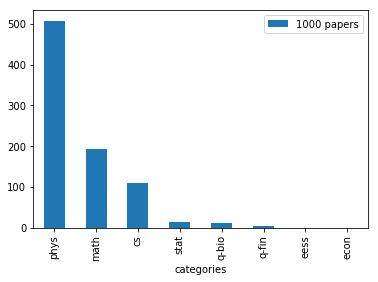

In [180]:
show_cats(all_data)

---

## Drop the least frequent categories: *Economics* and *Electrical Engineering and Systems Science*
The *eess* and *econ* categories had started only in year 2017. We are not ambitious enough at this point to include them in the classification. We will exculde them completely from our data, as if those categories did not exist in the world.

In [181]:
filter_ = np.vectorize(lambda cat: cat in ['econ', 'eess'])
drop_mask = filter_(all_data.primary_top_level_cat)

all_data = all_data.drop(all_data[drop_mask].index)

---

## Strip the data down to *text* + *label*. Replace whitespaces in the text with single spaces.

In [182]:
bare_data = pd.DataFrame()
bare_data['text'] = all_data.title.str.replace('\s+',' ') + ". " + all_data.abstract.str.replace('\s+',' ')
bare_data['label'] = all_data.primary_top_level_cat

In [183]:
with pd.option_context('display.max_colwidth', 120):
    display(bare_data[:3])

,text,label
0,"The Spitzer c2d Survey of Large, Nearby, Insterstellar Clouds. IX. The Serpens YSO Population As Observed With IRAC ...",phys
1,"On-line Viterbi Algorithm and Its Relationship to Random Walks. In this paper, we introduce the on-line Viterbi alg...",cs
2,Dynamical Objects for Cohomologically Expanding Maps. The goal of this paper is to construct invariant dynamical ob...,math


---

## Shuffle the data frame

In [184]:
bare_data = bare_data.sample(frac=1).reset_index(drop=True)

with pd.option_context('display.max_colwidth', 120):
    display(bare_data[:3])

,text,label
0,On the interplay between star formation and feedback in galaxy formation simulations. We investigate the star forma...,phys
1,Transversal Homotopy Monoids of Complex Projective Space. We will give a geometric description of the nth transvers...,math
2,Remarks on some typical assumptions in dynamo theory. Some concepts used in the theory of convection-driven dynamos...,phys


---

## Write to file

In [185]:
# sanity check
bare_data.isnull().sum().sum()

0

In [186]:
file = os.path.join("data", "bare_all.csv")
bare_data.to_csv(file, sep = '\t', index = False)

---

## Test the distribution of categories in smaller data chunks read back from file 

We have only 4600 articles from the *q-fin* category.
There is about 5 *q-fin*'s per 1000 articles.
Chunks of the data of volume smaller than tens of thousands risk having too unrepresentative of a sample to enable any resonable classification of the *q-fin* articles.

In [187]:
sum(bare_data.label=='q-fin'), round(sum(bare_data.label=='q-fin') / len(bare_data),4)

(4629, 0.0055)

A least, thanks to having shuffled the records before writing to file, we can now read from the top and hope for a representative distribution of the categories.

In [188]:
file = os.path.join("data", "bare_all.csv")

chunks = pd.read_csv(file, delimiter='\t', chunksize = 1000)

for _ in range(3):
    show_cats(next(chunks), column='label', divideby=10, showplot=False)

,10 papers
categories,
phys,58.1
math,25.3
cs,12.9
stat,2.2
q-fin,0.8
q-bio,0.7


,10 papers
categories,
phys,61.5
math,23.3
cs,12.0
stat,1.8
q-bio,0.9
q-fin,0.5


,10 papers
categories,
phys,61.8
math,21.9
cs,12.9
q-bio,1.5
stat,1.3
q-fin,0.6


---

### End